In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Data Preprocess and Visualization

In [3]:
# Read the dataset 
dataset = pd.read_csv("diabetes.csv")
# Drop rows that contain missing values
data = dataset.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   759 non-null    int64  
 1   Pregnancies               759 non-null    float64
 2   Glucose                   759 non-null    float64
 3   BloodPressure             759 non-null    float64
 4   SkinThickness             759 non-null    float64
 5   Insulin                   759 non-null    float64
 6   BMI                       759 non-null    float64
 7   DiabetesPedigreeFunction  759 non-null    float64
 8   Age                       759 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 59.3 KB


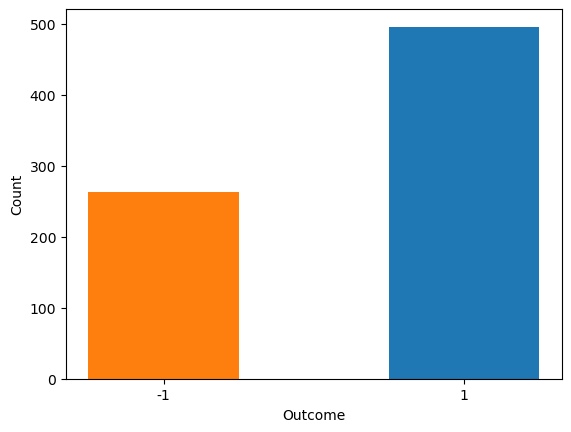

In [6]:
# Create a bar plot to visualize the distribution of 'Outcome' values
outcome_counts = data['Outcome'].value_counts()
plt.bar(outcome_counts.index, outcome_counts.values, color=['#1f77b4', '#ff7f0e'], width=1)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(outcome_counts.index, labels=['1', '-1'])
plt.show()

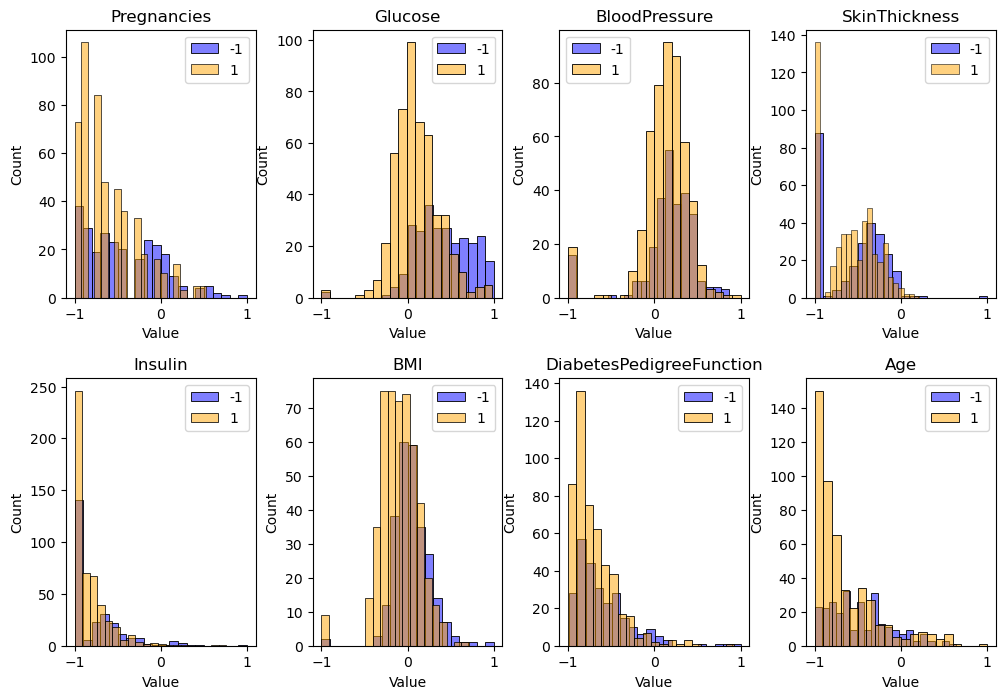

In [5]:
# Separate data by Outcome
df_1 = data[data['Outcome'] == -1]
df1 = data[data['Outcome'] == 1]

# Get feature columns
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

# Plot each feature distribution
for i, feature in enumerate(feature_columns):
    ax = axes[i]
    sns.histplot(data=df_1, x=feature, bins=20, color='blue', alpha=0.5, label='-1', ax=ax)
    sns.histplot(data=df1, x=feature, bins=20, color='orange', alpha=0.5, label='1', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend()

plt.show()


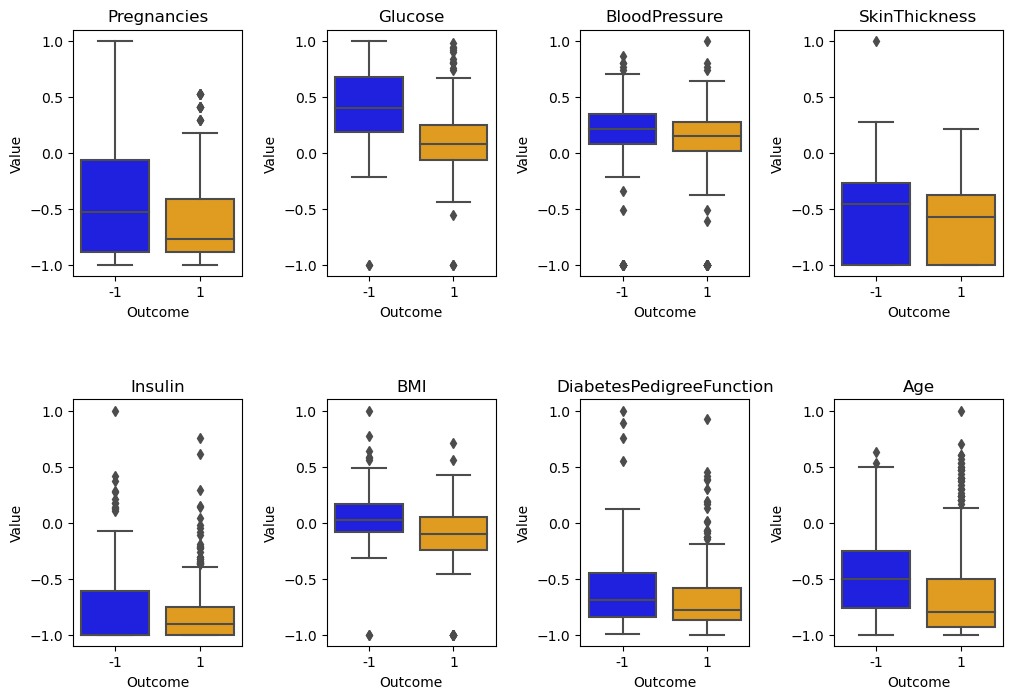

In [7]:
# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
axes = axes.flatten()

# Plot each feature distribution as boxplots
for i, feature in enumerate(feature_columns):
    ax = axes[i]
    sns.boxplot(data=data, x='Outcome', y=feature, ax=ax, palette=['blue', 'orange'])
    ax.set_title(feature)
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Value')

plt.show()


# Multi-layer Perceptron Implement

In [8]:
# X is feature matrix and y is the target vector
X = data.drop("Outcome",axis=1).values
y = dataset["Outcome"].values
y = np.where(y == -1, 0, y)

# Calculate the total number of samples 
samples = X.shape[0]

# Define the proportions for training, validation, and test sets
train_proportion = 0.7   
val_proportion = 0.15   

# Calculate the sizes of each split based on the proportions
train_size = int(train_proportion * samples)
val_size = int(val_proportion * samples)
test_size = samples - train_size - val_size

# Split the data into training, validation, and test sets
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Convert the data splits to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [9]:
# Check if a CUDA-enabled GPU is available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cpu


##  Single-layer Perceptron

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
features = data.drop('Outcome', axis=1)
target = data['Outcome']

# Split the data into training and testing sets using a random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=16)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Perceptron model
perceptron_model = Perceptron()

# Train the Perceptron Model
perceptron_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = perceptron_model.predict(X_test_scaled)

# Calculate and print the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 63.16%


## Two-Layer Perceptron(best)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
         # Define the model architecture
        self.layers = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),# Input layer to hidden layer
        nn.ReLU(),# Using ReLU activation function
        nn.Linear(hidden_dim, hidden_dim), # Hidden layer to output layer
         )
        # Parameter initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight) # Initialize weights using Xavier initialization
                nn.init.zeros_(layer.bias)# Initialize biases to zero

    def forward(self, x):
        return self.layers(x)

In [13]:
# Set a fixed random seed for reproducibility
torch.manual_seed(16)

# Initialize model, loss function, and optimizer
input_dimension = X_train.shape[1]  
hidden_dimension = 35  # Number of neurons in the hidden layer
output_dimension = 2  # binary classification
learning_rate = 0.01  

mlp_model = MLP(input_dimension, hidden_dimension, output_dimension)  
loss_criterion = nn.CrossEntropyLoss()  # Define the loss function
weight_decay_coefficient = 0.004  # Weight decay for regularization
optimizer = optim.SGD(mlp_model.parameters(), lr=learning_rate, weight_decay=weight_decay_coefficient)

# Initialize lists to store accuracies and losses
training_accuracies, validation_accuracies, training_losses = [], [], []

# Training loop
for epoch in range(100):  
    print(f'Starting epoch {epoch + 1}')

    # Forward pass
    outputs = mlp_model(X_train_tensor)
    loss = loss_criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss value
    training_losses.append(loss.item())

    # Calculate and store Training Accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).float().mean()
        training_accuracies.append(train_accuracy)

        # Calculate and store Validation Accuracy
        val_outputs = mlp_model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).float().mean()
        validation_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print('Training process has finished.')
best_validation_accuracy = max(validation_accuracies)
print(f"The best validation accuracy: {best_validation_accuracy:.4f}")


Starting epoch 1
Epoch 1, Loss: 3.4065, Train Accuracy: 0.0565, Validation Accuracy: 0.0796
Starting epoch 2
Epoch 2, Loss: 3.3903, Train Accuracy: 0.0772, Validation Accuracy: 0.1062
Starting epoch 3
Epoch 3, Loss: 3.3740, Train Accuracy: 0.1186, Validation Accuracy: 0.1681
Starting epoch 4
Epoch 4, Loss: 3.3576, Train Accuracy: 0.1488, Validation Accuracy: 0.1947
Starting epoch 5
Epoch 5, Loss: 3.3411, Train Accuracy: 0.1808, Validation Accuracy: 0.2389
Starting epoch 6
Epoch 6, Loss: 3.3246, Train Accuracy: 0.2241, Validation Accuracy: 0.3009
Starting epoch 7
Epoch 7, Loss: 3.3079, Train Accuracy: 0.2599, Validation Accuracy: 0.3805
Starting epoch 8
Epoch 8, Loss: 3.2911, Train Accuracy: 0.3089, Validation Accuracy: 0.4248
Starting epoch 9
Epoch 9, Loss: 3.2743, Train Accuracy: 0.3653, Validation Accuracy: 0.4956
Starting epoch 10
Epoch 10, Loss: 3.2572, Train Accuracy: 0.4218, Validation Accuracy: 0.5221
Starting epoch 11
Epoch 11, Loss: 3.2401, Train Accuracy: 0.4689, Validation A

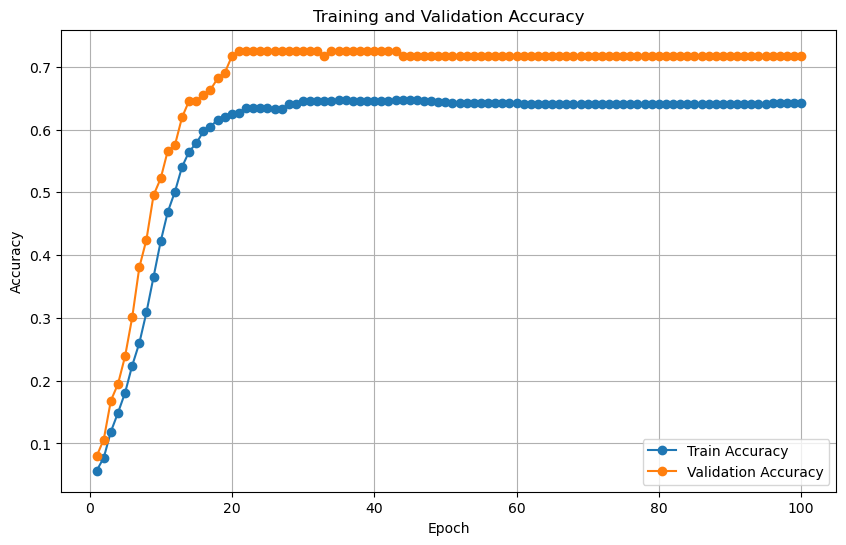

In [14]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, len(training_accuracies) + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracies, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


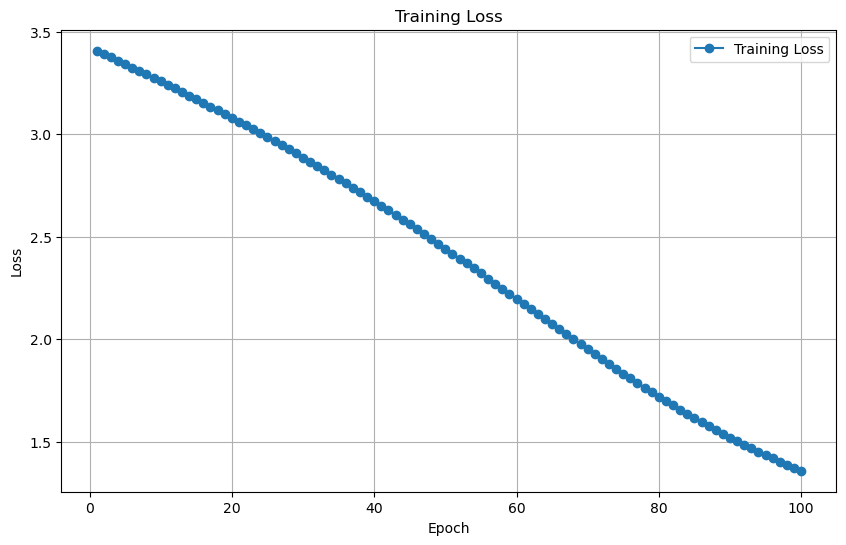

In [15]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, len(training_losses) + 1)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()



## Three-Layer Perceptron

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        # Define the model architecture with three hidden layers
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),  # Input layer to first hidden layer
            nn.ReLU(),  # Using ReLU activation function
            nn.Linear(hidden_dim1, hidden_dim2),  # First hidden layer to second hidden layer
            nn.ReLU(),  # Using ReLU activation function
            nn.Linear(hidden_dim2, output_dim),  # Second hidden layer to output layer
        )
        # Parameter initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)  # Initialize weights using Xavier initialization
                nn.init.zeros_(layer.bias)  # Initialize biases to zero

    def forward(self, x):
        return self.layers(x)

In [17]:
# Set a fixed random seed for reproducibility
torch.manual_seed(16)

# Initialize model, loss function, and optimizer for the three-layer MLP
input_dimension = X_train.shape[1] 
hidden_dimension1 = 50  # Number of neurons in the first hidden layer
hidden_dimension2 = 35  # Number of neurons in the second hidden layer
output_dimension = 2  # binary classification
learning_rate = 0.01 

# Create the three-layer MLP model
mlp_model = MLP(input_dimension, hidden_dimension1, hidden_dimension2, output_dimension)

# Define the loss function
loss_criterion = nn.CrossEntropyLoss()

# Weight decay for regularization
weight_decay_coefficient = 0.004

# Create the optimizer
optimizer = optim.SGD(mlp_model.parameters(), lr=learning_rate, weight_decay=weight_decay_coefficient)

# Initialize lists to store accuracies and losses
training_accuracies, validation_accuracies, training_losses = [], [], []

# Training loop
for epoch in range(100):
    print(f'Starting epoch {epoch + 1}')

    # Forward pass
    outputs = mlp_model(X_train_tensor)
    loss = loss_criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss value
    training_losses.append(loss.item())

    # Calculate and store Training Accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).float().mean()
        training_accuracies.append(train_accuracy)

        # Calculate and store Validation Accuracy
        val_outputs = mlp_model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).float().mean()
        validation_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print('Training process has finished.')
best_validation_accuracy = max(validation_accuracies)
print(f"The best validation accuracy: {best_validation_accuracy:.4f}")


Starting epoch 1
Epoch 1, Loss: 0.6625, Train Accuracy: 0.6516, Validation Accuracy: 0.7080
Starting epoch 2
Epoch 2, Loss: 0.6618, Train Accuracy: 0.6535, Validation Accuracy: 0.7080
Starting epoch 3
Epoch 3, Loss: 0.6611, Train Accuracy: 0.6535, Validation Accuracy: 0.7080
Starting epoch 4
Epoch 4, Loss: 0.6605, Train Accuracy: 0.6497, Validation Accuracy: 0.7080
Starting epoch 5
Epoch 5, Loss: 0.6599, Train Accuracy: 0.6516, Validation Accuracy: 0.7080
Starting epoch 6
Epoch 6, Loss: 0.6592, Train Accuracy: 0.6478, Validation Accuracy: 0.7080
Starting epoch 7
Epoch 7, Loss: 0.6587, Train Accuracy: 0.6478, Validation Accuracy: 0.7080
Starting epoch 8
Epoch 8, Loss: 0.6581, Train Accuracy: 0.6460, Validation Accuracy: 0.7080
Starting epoch 9
Epoch 9, Loss: 0.6576, Train Accuracy: 0.6441, Validation Accuracy: 0.7080
Starting epoch 10
Epoch 10, Loss: 0.6571, Train Accuracy: 0.6441, Validation Accuracy: 0.7080
Starting epoch 11
Epoch 11, Loss: 0.6566, Train Accuracy: 0.6441, Validation A

# Improvement

In [18]:
# Set a fixed random seed for reproducibility
torch.manual_seed(16)

# Define an MLP model with Dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(MLPWithDropout, self).__init__()
        # Define the model architecture, including the Dropout layer
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Input layer to hidden layer
            nn.ReLU(),  # Using ReLU activation function
            nn.Dropout(p=dropout_prob),  # Add a Dropout layer with dropout probability 'p'
            nn.Linear(hidden_dim, hidden_dim),  # Hidden layer to output layer
        )
        # Parameter initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)  # Initialize weights using Xavier initialization
                nn.init.zeros_(layer.bias)  # Initialize biases to zero

    def forward(self, x):
        return self.layers(x)

In [19]:
# Create an MLP model with Dropout
input_dimension = X_train.shape[1] 
hidden_dimension = 35  # Number of neurons in the hidden layer
output_dimension = 2  # binary classification
learning_rate = 0.01  
dropout_probability = 0.5 

mlp_model_with_dropout = MLPWithDropout(input_dimension, hidden_dimension, output_dimension, dropout_prob=dropout_probability)

# Define the loss function and optimizer
loss_criterion = nn.CrossEntropyLoss()
weight_decay_coefficient = 0.004  # Weight decay for regularization
optimizer = optim.SGD(mlp_model_with_dropout.parameters(), lr=learning_rate, weight_decay=weight_decay_coefficient)

# Initialize lists to store accuracies and losses
training_accuracies, validation_accuracies, training_losses = [], [], []

# Training loop
for epoch in range(100):
    print(f'Starting epoch {epoch + 1}')

    # Forward pass
    outputs = mlp_model_with_dropout(X_train_tensor)
    loss = loss_criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss value
    training_losses.append(loss.item())

    # Calculate and store Training Accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == y_train_tensor).float().mean()
        training_accuracies.append(train_accuracy)

        # Calculate and store Validation Accuracy
        val_outputs = mlp_model_with_dropout(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_tensor).float().mean()
        validation_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print('Training process has finished.')
best_validation_accuracy = max(validation_accuracies)
print(f"The best validation accuracy: {best_validation_accuracy:.4f}")


Starting epoch 1
Epoch 1, Loss: 3.4251, Train Accuracy: 0.0490, Validation Accuracy: 0.0619
Starting epoch 2
Epoch 2, Loss: 3.4112, Train Accuracy: 0.0960, Validation Accuracy: 0.0619
Starting epoch 3
Epoch 3, Loss: 3.4139, Train Accuracy: 0.0772, Validation Accuracy: 0.0973
Starting epoch 4
Epoch 4, Loss: 3.3818, Train Accuracy: 0.0942, Validation Accuracy: 0.1239
Starting epoch 5
Epoch 5, Loss: 3.3677, Train Accuracy: 0.1055, Validation Accuracy: 0.1327
Starting epoch 6
Epoch 6, Loss: 3.3479, Train Accuracy: 0.1450, Validation Accuracy: 0.1416
Starting epoch 7
Epoch 7, Loss: 3.3279, Train Accuracy: 0.1262, Validation Accuracy: 0.2035
Starting epoch 8
Epoch 8, Loss: 3.3041, Train Accuracy: 0.1864, Validation Accuracy: 0.2124
Starting epoch 9
Epoch 9, Loss: 3.2887, Train Accuracy: 0.2109, Validation Accuracy: 0.2124
Starting epoch 10
Epoch 10, Loss: 3.2689, Train Accuracy: 0.2316, Validation Accuracy: 0.2566
Starting epoch 11
Epoch 11, Loss: 3.2644, Train Accuracy: 0.2505, Validation A

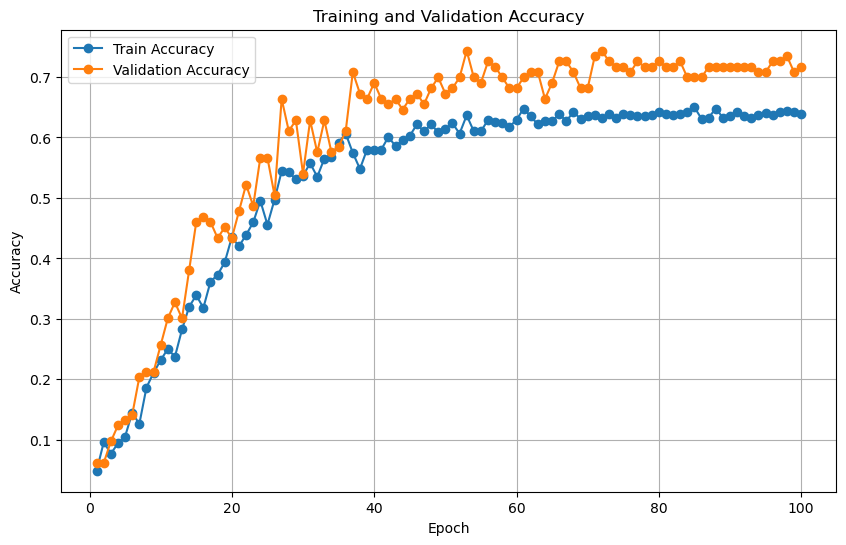

In [20]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, len(training_accuracies) + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracies, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


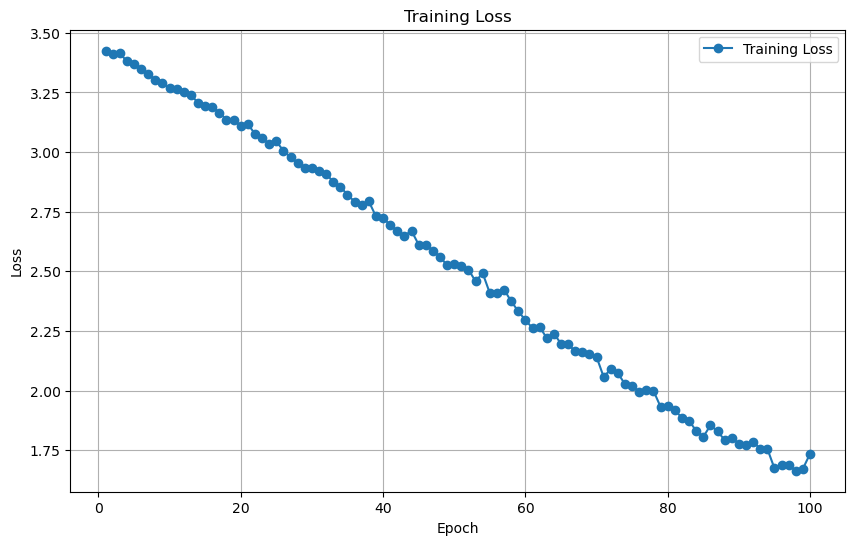

In [21]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, len(training_losses) + 1)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
